In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 
import wandb

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

sys.path.append("../")
from src.model import LightGBMModel
from src.validation import caluculate_metrics



# Config

In [3]:
class cfg:
    project = "numerai_tournament"
    exp = "exp024"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    valid_ratio = 0.2
    description = ""
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }

has_init_wandb = False
if not has_init_wandb:
    wandb.init(project=cfg.project, name=cfg.exp)
    wandb.log({
        "description": cfg.description,
        "feature_set": cfg.feature_set,
    })
    has_init_wandb = True

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ko_ya346 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: creating run
wandb: Tracking run with wandb version 0.19.7
wandb: Run data is saved locally in /home/kouya-takahashi/numerai/notebook/wandb/run-20250225_091829-be1t9txp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exp024
wandb: ⭐️ View project at https://wandb.ai/ko_ya346/numerai_tournament
wandb: 🚀 View run at https://wandb.ai/ko_ya346/numerai_tournament/runs/be1t9txp


In [4]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set][:80]
print(f"feature col length: {len(feature_set)}")


targets_list = feature_metadata["targets"]
targets = targets_list

feature col length: 42


# Load Data

In [5]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era"] + feature_set + targets
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era"] + feature_set + targets
    
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,2,2,2,2,2,0,1,2,2,...,0.5,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.00,0.25
n003bba8a98662e4,0001,2,2,2,2,2,1,4,2,2,...,0.5,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.25


(3590190, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0,2,1,2,2,1,1,2,2,...,0.50,0.75,0.50,0.5,0.50,0.50,0.50,0.75,0.50,0.75
n001e1318d5072ac,0575,1,1,3,2,1,3,3,4,4,...,0.25,0.25,0.25,0.0,0.25,0.25,0.25,0.25,0.25,0.00


# Preprocess

In [6]:
# 学習データを増やす (train, valid を合体してから分ける)
print(train.shape, valid.shape)

data = pd.concat([train, valid])
display(data.tail())

# era 単位で分ける
all_era = data["era"].unique()
n_idx = int(len(all_era) * (1 - cfg.valid_ratio))
print(data.shape)
print(n_idx)

train_era = all_era[:n_idx]
cond_train = data["era"].isin(train_era)
train, valid = data.loc[cond_train], data.loc[~cond_train]

print(train.shape, valid.shape)


(2746270, 80) (3590190, 80)


,era,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,feature_donnard_groutier_twinkle,...,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60,target
id,,,,,,,,,,,,,,,,,,,,,
nffddb5d88eac837,1155,1,2,4,1,1,4,3,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffe2864d87608a4,1155,4,4,2,4,4,3,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffe68d1b4270d67,1155,2,0,1,0,3,0,2,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nffeedfcd8ee0a13,1155,2,1,1,2,2,4,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nfff368efc94f367,1155,4,2,3,3,3,3,4,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(6336460, 80)
924
(4830256, 80) (1506204, 80)


In [7]:
train["era_int"] = train["era"].astype(int)

/tmp/ipykernel_167785/1731592198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["era_int"] = train["era"].astype(int)


# Training

In [8]:
features = feature_set


In [9]:
models = []

for target in targets:
    print("=" * 64)
    print("target: ", target)

    # 学習データを取り出す間隔を設定
    # target または 末尾に 20 がついてるもの: 4
    # 末尾に 60 がついてるもの: 12
    if target == "target" or target[-2:] == "20":
        blank = 4
    elif target[-2:] == "60":
        blank = 12
    else:
        raise ValueError(f"Unknown target: {target}")
        
    for i in range(blank):
        cond_train = (train["era_int"] % blank == i) & (~train[target].isnull())
        cond_valid = ~valid[target].isnull()
        tmp_train = train.loc[cond_train]
        tmp_valid = valid.loc[cond_valid]

        model = LightGBMModel(
            model_params=cfg.model_params,
        )
        model.train(
            tmp_train[features],
            tmp_train[target],
            eval_set=(tmp_valid[features], tmp_valid[target]),
            early_stopping_rounds=10
        )
        models.append(model)
        model.save_model(os.path.join(cfg.exp, f"model_{i}_{target}.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

target:  target_agnes_20


/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1201983, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1199767, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1201532, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1201904, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 398917, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 395385, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 396065, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 395919, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 395402, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 396006, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 396332, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 396641, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 397232, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 397944, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 398644, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 398852, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404733, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400920, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401569, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401469, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 400899, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401465, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 401898, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402147, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 402756, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 403515, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404309, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 404576, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208388, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1205900, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1207776, number of used features: 42
[LightGBM] [Warning] Provided parameters con

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 1208192, number of used features: 42
[LightGBM] [Warning] Provided parameters con

292


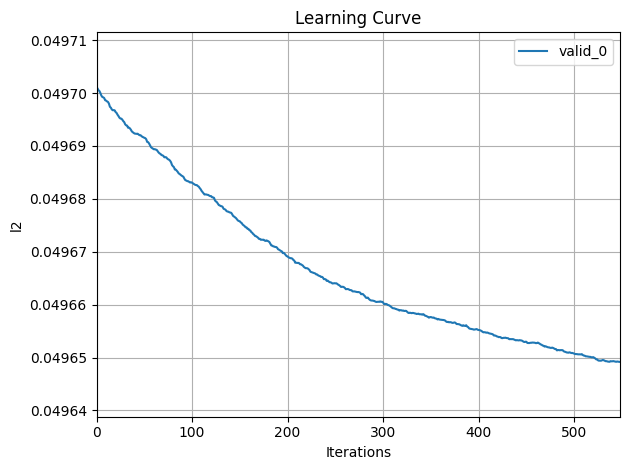

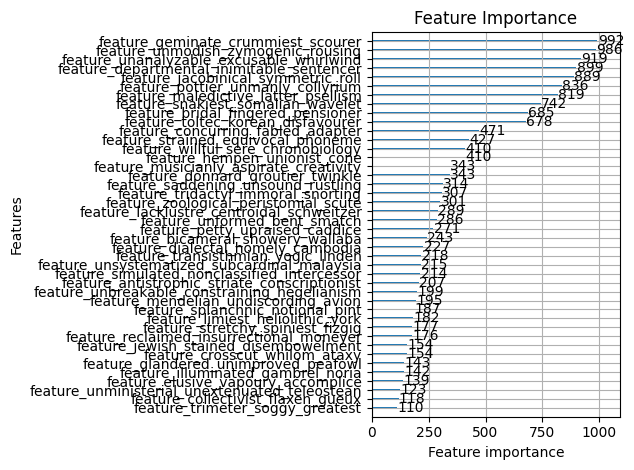

In [10]:
print(len(models))

for model in models:
    model.visualize_learning_curve()
    model.visualize_feature_importance()
    break

# Validation

/tmp/ipykernel_167785/4041851832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["pred"] = preds


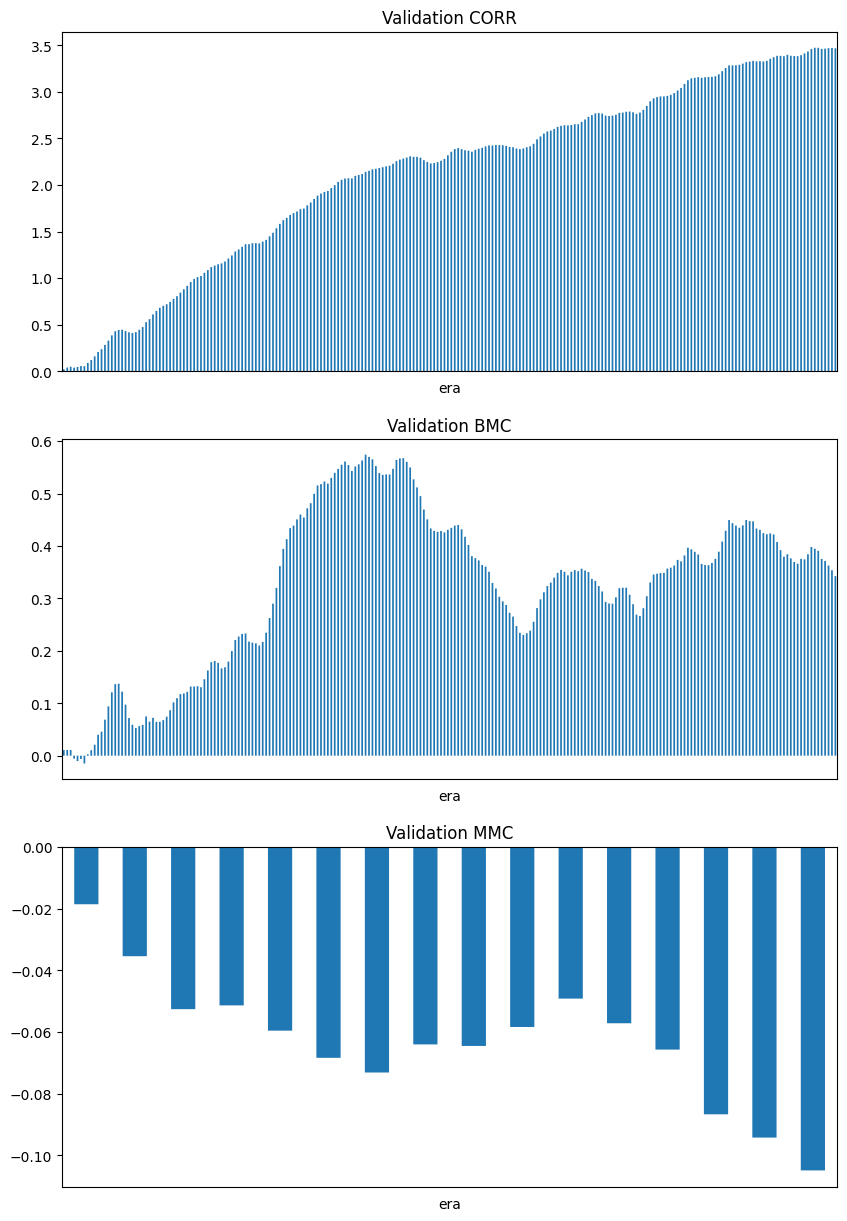

In [11]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds
result, per_era_corr, per_era_bmc, per_era_mmc = caluculate_metrics(cfg.dataset_path, valid)


In [12]:
# 損益曲線も wandb上で可視化したかったが log で送ると GUI がバグる
# 総和を連携する

per_era_d = {
    "per_era_corr": per_era_corr,
    "per_era_bmc": per_era_bmc,
    "per_era_mmc": per_era_mmc,
}


for key, val in per_era_d.items():
    print(key)
    # display(val.head())
    total_val = val["pred"].sum()
    wandb.log({
        key: total_val
        # key: []
    })
    

per_era_corr
per_era_bmc
per_era_mmc


In [13]:
cond = ~valid["target"].isnull()
tmp_valid = valid.loc[cond]
mse = round(mean_squared_error(tmp_valid["pred"], tmp_valid["target"]), 6)

print(mse)
result_d = {key: round(val[0], 6)for key, val in result.to_dict().items()}
n_features = len(features)

result_d["mse"] = mse
result_d["targets"] = targets

print(result_d)
wandb.log(result_d)

0.049829
{'corr_mean': 0.015343, 'corr_std': 0.016601, 'corr_shape': 0.924194, 'corr_max_drawdown': 0.076969, 'mmc_mean': -0.006552, 'mmc_std': 0.009512, 'mmc_shape': -0.688861, 'mmc_max_drawdown': 0.086248, 'bmc_mean': 0.001516, 'bmc_std': 0.01215, 'bmc_shape': 0.124737, 'bmc_max_drawdown': 0.34378, 'mse': 0.049829, 'targets': ['target_agnes_20', 'target_agnes_60', 'target_alpha_20', 'target_alpha_60', 'target_bravo_20', 'target_bravo_60', 'target_caroline_20', 'target_caroline_60', 'target_charlie_20', 'target_charlie_60', 'target_claudia_20', 'target_claudia_60', 'target_cyrusd_20', 'target_cyrusd_60', 'target_delta_20', 'target_delta_60', 'target_echo_20', 'target_echo_60', 'target_jeremy_20', 'target_jeremy_60', 'target_ralph_20', 'target_ralph_60', 'target_rowan_20', 'target_rowan_60', 'target_sam_20', 'target_sam_60', 'target_teager2b_20', 'target_teager2b_60', 'target_tyler_20', 'target_tyler_60', 'target_victor_20', 'target_victor_60', 'target_waldo_20', 'target_waldo_60', 'ta

In [14]:
wandb.finish()

wandb: uploading output.log; uploading config.yaml
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  bmc_max_drawdown ▁
wandb:          bmc_mean ▁
wandb:         bmc_shape ▁
wandb:           bmc_std ▁
wandb: corr_max_drawdown ▁
wandb:         corr_mean ▁
wandb:        corr_shape ▁
wandb:          corr_std ▁
wandb:  mmc_max_drawdown ▁
wandb:          mmc_mean ▁
wandb:         mmc_shape ▁
wandb:           mmc_std ▁
wandb:               mse ▁
wandb:       per_era_bmc ▁
wandb:      per_era_corr ▁
wandb:       per_era_mmc ▁
wandb: 
wandb: Run summary:
wandb:  bmc_max_drawdown 0.34378
wandb:          bmc_mean 0.00152
wandb:         bmc_shape 0.12474
wandb:           bmc_std 0.01215
wandb: corr_max_drawdown 0.07697
wandb:         corr_mean 0.01534
wandb:        corr_shape 0.92419
wandb:          corr_std 0.0166
wandb:       description 
wandb:       feature_set small
wandb:  mmc_max_drawdown 0.08625
wandb:          mmc_m